In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 600

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "rice leaves",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3358 files belonging to 5 classes.


In [4]:
class_names=dataset.class_names
class_names

['BrownSpot', 'Garbage', 'Healthy', 'Hispa', 'LeafBlast']

(32, 256, 256, 3)
[1 2 3 4 0 0 4 4 3 2 2 2 4 1 2 2 1 2 3 1 1 2 2 1 3 1 1 2 0 4 2 2]


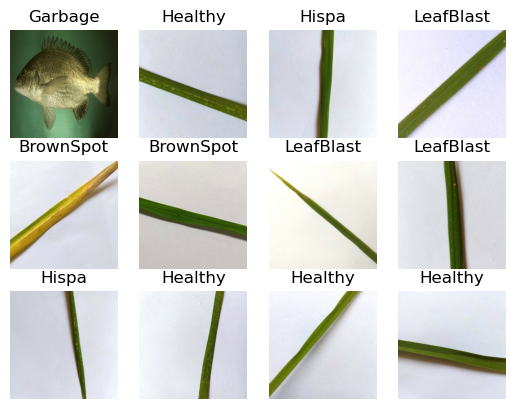

In [5]:
for image_batch,layers_batch in dataset.take(1):
    print(image_batch.shape)
    print(layers_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[layers_batch[i]])
        plt.axis("off")

In [6]:
len(dataset)

105

In [7]:
84*32

2688

In [8]:
def get_dataset_partition_tf(ds, train_spilt=0.7,val_spilt=0.1,test_spilt=0.2,shuffle=True,shuffle_size=10000):
    assert(train_spilt+val_spilt+test_spilt) == 1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(ds_size*train_spilt)
    val_size=int(ds_size*val_spilt)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [10]:
len(train_ds)

73

In [11]:
len(val_ds)

10

In [12]:
len(test_ds)

22

In [13]:
(67*32)+(8*32)+(9*32)

2688

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
for image_batch, layers_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.9764706  0.99215686 0.99607843]
  [0.98039216 0.99607843 1.        ]
  [0.98039216 0.99607843 1.        ]
  ...
  [0.9411765  0.9529412  0.98039216]
  [0.9411765  0.9529412  0.972549  ]
  [0.9411765  0.9529412  0.972549  ]]

 [[0.9607843  0.9764706  0.98039216]
  [0.9647059  0.98039216 0.9843137 ]
  [0.96862745 0.9843137  0.9882353 ]
  ...
  [0.9372549  0.9490196  0.9764706 ]
  [0.9372549  0.9490196  0.96862745]
  [0.9372549  0.9490196  0.96862745]]

 [[0.9607843  0.9764706  0.98039216]
  [0.9647059  0.98039216 0.9843137 ]
  [0.96862745 0.9843137  0.9882353 ]
  ...
  [0.92941177 0.9411765  0.96862745]
  [0.92941177 0.9411765  0.96862745]
  [0.9254902  0.9372549  0.9647059 ]]

 ...

 [[0.8745098  0.88235295 0.92941177]
  [0.8784314  0.8862745  0.93333334]
  [0.88235295 0.8901961  0.9372549 ]
  ...
  [0.88235295 0.8784314  0.93333334]
  [0.8901961  0.8862745  0.9411765 ]
  [0.8980392  0.89411765 0.9490196 ]]

 [[0.8901961  0.8901961  0.9372549 ]
  [0.89411765 0.89411765 0.9411765 ]


In [16]:
resizing_and_rescaling=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=5

model = models.Sequential([
    resizing_and_rescaling,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    Dropout(0.4),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.MaxPooling2D((2,2)),
    Dropout(0.4),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.MaxPooling2D((2,2)),
    Dropout(0.4),
    layers.Conv2D(64, (3,3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.MaxPooling2D((2,2)),
    Dropout(0.4),
    layers.Conv2D(128, (3,3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    layers.MaxPooling2D((2,2)),
    Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    Dropout(0.2),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    
)

Epoch 1/600


73/73 [==============================] - 157s 2s/step - loss: 3.8192 - accuracy: 0.3350 - val_loss: 3.3018 - val_accuracy: 0.3187
Epoch 2/600


In [ ]:
len(test_ds)

In [ ]:
scores=model.evaluate(test_ds)

In [ ]:
history.history.keys()

In [ ]:
history.history['loss']

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training_accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation_accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training_loss')
plt.plot(range(EPOCHS),val_loss,label='Validation_loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Disease: ", class_names[labels_batch[0].numpy()])
    
    batch_predict=model.predict(images_batch)
    print("Predicted Disease: ",class_names[np.argmax(batch_predict[0])])
    

In [ ]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    prediction=model.predict(img_array)
    predict_cls=class_names[np.argmax(prediction[0])]
    confidence=round(100 * (np.max(prediction[0])), 2)
    return predict_cls,confidence
    

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[0].numpy().astype("uint8"))
        predicted_class, confidence= predict(model,images[i].numpy())
        
        actual_cls=class_names[labels[i]]
        plt.title(f"Actual: {actual_cls} \n Predicted : {predicted_class} \n Confidence : {confidence}%")
        plt.axis("off")

In [ ]:
import os
model_version=max([int(i) for i in(os.listdir("../models")+[0])])+1
model.save(f"../models/{model_version}")